# Global

In [5]:
model_saved_name="model_colab.ckpt"
dataset_path=r"data\std_dataset"

# path using \ instead of /

## processing...

In [6]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import NW_LSTM
import NN_DataLoader

# Check if CUDA is available and if so, set the device to GPU
device = torch.device("cpu")
print("Device using ", device)

# Instantiate the model with appropriate dimensions
model = NW_LSTM.get_global_model().to(device)

# load model from ckpt file
model.load_state_dict(torch.load(model_saved_name))


class MyDataset(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.float32)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]



Device using  cpu


Data size  4071
model parameters:  9009


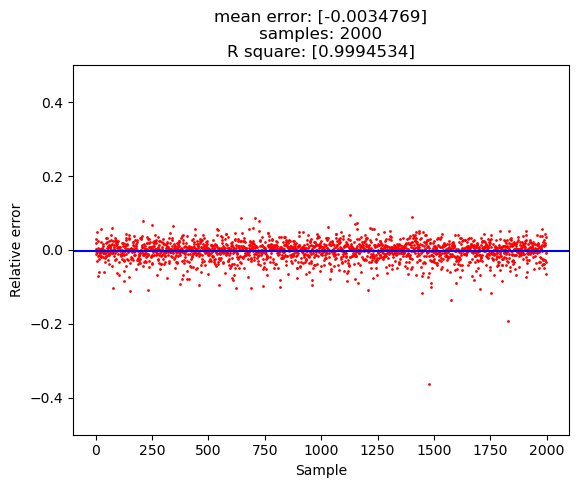

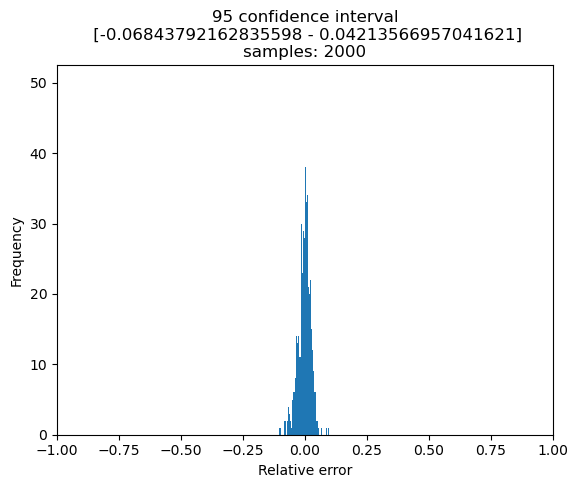

[[ 15705.57519531  15252.97558594]
 [639425.125      642058.8125    ]
 [733030.5625     741938.0625    ]
 [ 55918.6953125   54942.64453125]]


In [7]:
import Maglib

magData = Maglib.MagLoader(dataset_path+r"\test.mat")

x_data = np.zeros([magData.b.shape[0], magData.b.shape[1], 3])
x_data[:, :, 0] = magData.b
x_data[:, :, 1] = magData.freq
x_data[:, :, 2] = magData.temp

idx = 0
dataNums = magData.freq.shape[0]
# no more than 2000
if(dataNums>2000):dataNums=2000


x_data = x_data[idx:idx + dataNums, :, :]
y_data = magData.loss[idx:idx + dataNums, :]

# Now we can pass a batch of sequences through the model
inputs = torch.tensor(x_data, dtype=torch.float32)

outputs = model(inputs)

total_params = sum(p.numel() for p in model.parameters())

print('Data size ', magData.b.shape[0])
print('model parameters: ', total_params)

# get model performance

# get loss
pred = outputs.detach().numpy()
real = y_data

import linear_std

std_loss = linear_std.linear_std()
std_loss.load(dataset_path+r"\std_loss.stdd")

pred = std_loss.unstd(pred)
real = std_loss.unstd(real)

error = (pred - real) / real
error_mean = np.mean(error, axis=0)
# calculate the 95% confidence interval
error_95 = list(
    [np.percentile(error, 2.5, axis=0),
     np.percentile(error, 97.5, axis=0)])

# calculate r square error
r_square= 1 - np.sum((pred - real)**2, axis=0) / np.sum((real - np.mean(real, axis=0))**2, axis=0)

plt.plot(error, '.', color='r', markersize=2)
# draw a horizontal line at 0
plt.axhline(y=error_mean, color='b', linestyle='-')

# use title to express mean loss
plt.title("mean error: " + str(error_mean) +
    '\nsamples: ' + str(len(y_data))+
    '\nR square: '+str(r_square)
    )
plt.xlabel('Sample')
plt.ylabel('Relative error')

plt.ylim(-0.5, 0.5)
plt.show()

data_display = np.zeros([4, 2])
data_display[:, 0] = pred[0:4, 0]
data_display[:, 1] = real[0:4, 0]

# plot the distribution of error
plt.figure()
plt.title("95 confidence interval\n [{} - {}]".format(
    float(error_95[0]), float(error_95[1])) +
    '\nsamples: ' + str(len(y_data)))
plt.xlim(-1, 1)
plt.hist(error, bins=500)
plt.ylabel('Frequency')
plt.xlabel('Relative error')
plt.show()

print(data_display)


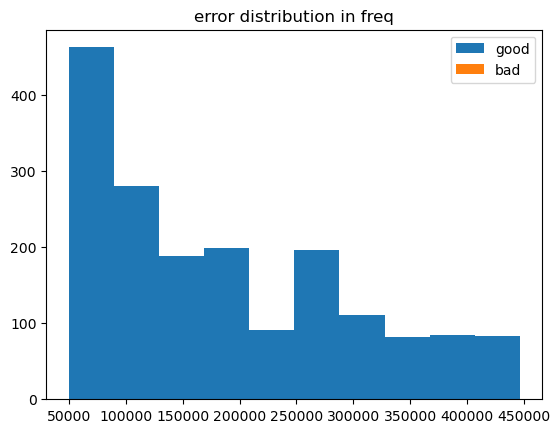

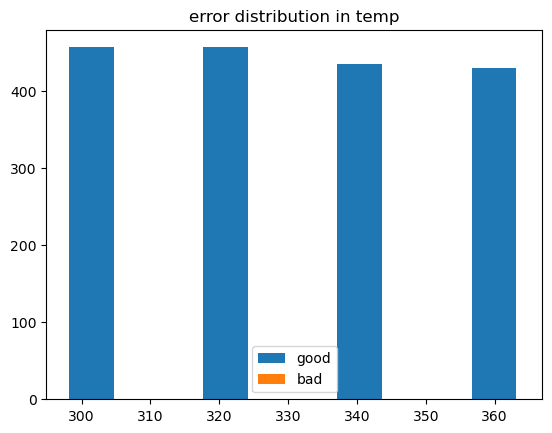

In [8]:
bad_example=[]
good_example=[]
for idx in range(error.shape[0]):
    if abs(error[idx])>0.2:
        bad_example.append(idx)
    elif abs(error[idx])<0.04:
        good_example.append(idx)


std_temp= linear_std.linear_std()
std_temp.load(dataset_path+r"\std_temp.stdd")

std_freq= linear_std.linear_std()
std_freq.load(dataset_path+r"\std_freq.stdd")


bad_freq=[]
bad_temp=[]

good_freq=[]
good_temp=[]

for idx in bad_example:
    bad_freq.append(std_freq.unstd(magData.freq[idx]))
    bad_temp.append(std_temp.unstd(magData.temp[idx]))

for idx in good_example:
    good_freq.append(std_freq.unstd(magData.freq[idx]))
    good_temp.append(std_temp.unstd(magData.temp[idx]))


# plot the distribution of good_freq vs bad_freq
plt.figure()
plt.title("error distribution in freq")
plt.hist(np.array(good_freq),label="good")
plt.hist(np.array(bad_freq),label="bad")
plt.legend()
plt.show()

# plot the distribution of good_temp vs bad_temp
plt.figure()
plt.title("error distribution in temp")
plt.hist(np.array(good_temp),label="good")
plt.hist(np.array(bad_temp),label="bad")
plt.legend()
plt.show()

# plot the distribution of error
drawing=False

if drawing:
    for idx in bad_example:
        plt.figure()
        # using title to show the temp and freq
        plt.title('temp: ' + str(std_temp.unstd(magData.temp[idx])) +
                '\nfreq: ' + str(std_freq.unstd(magData.freq[idx])))

        plt.plot(magData.b[idx,:])
        plt.show()